# Group Assignment TM10007 - Machine Learning

Group 3
Noor Borren
Puck Groen 4470044
Lucy Knöps 
Judith Sluijter

In [1]:
# Import
from hn.load_data import load_data

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, decomposition, svm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [2]:
# Functions

def data_preprocessing_pca(X_train, X_validation):
    ''' Data preprocessing: first scaling and then PCA with a optimized number of components '''

    # 1. Scaling 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Principle component analysis
    # Using the cumulative summation of the explained variance, we concluded that in
    # order to retain 95% of the variance 30 components are needed.

    pca = PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)

    return X_train_pca, X_validation_pca


def data_preprocessing_uni(X_train, y_train, X_validation):
    '''Data preprocessing: first scaling and then univariate analysis'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)

    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  # Naming the dataframe columns
    best_features = featureScores.nlargest(10,'Score')['Specs']

    X_train_uni = df_X_train_scaled[best_features]
    X_validation_uni = df_X_validation_scaled[best_features]

    return X_train_uni, X_validation_uni


def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

# Data Loading

In [3]:
# Loading of the data 
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = preprocessing.label_binarize(y_labels, ['T12', 'T34']) 
# 0 stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

# Split data in a train and test set
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y, stratify=y, test_size=0.2)

The number of samples: 113
The number of features: 159


# kNN Classifier

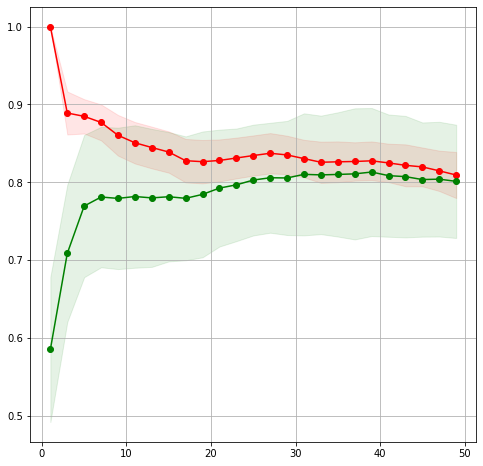

In [4]:
# Classifier: kNN
# Preprocessing: PCA
# Dataset: training & validation

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)

k_list = list(range(1, 50, 2))
all_train = []
all_validation = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        validation_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_pca, X_validation_pca = data_preprocessing_pca(X_train, X_validation)

        for k in k_list:
            clf_knn = KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(X_train_pca)[:, 1]
            validation_proba = clf_knn.predict_proba(X_validation_pca)[:, 1]
            
            score_train = metrics.roc_auc_score(y_train, train_proba)
            score_validation = metrics.roc_auc_score(y_validation, validation_proba)

            train_scores.append(score_train)
            validation_scores.append(score_validation)

        all_train.append(train_scores)
        all_validation.append(validation_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_validation = np.array(all_validation)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

validation_scores_mean = all_validation.mean(axis=0)
validation_scores_std = all_validation.std(axis=0)

# Plot the learning curve (mean scores and std as shading)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, validation_scores_mean, 'o-', color="g",
        label="Validation score")

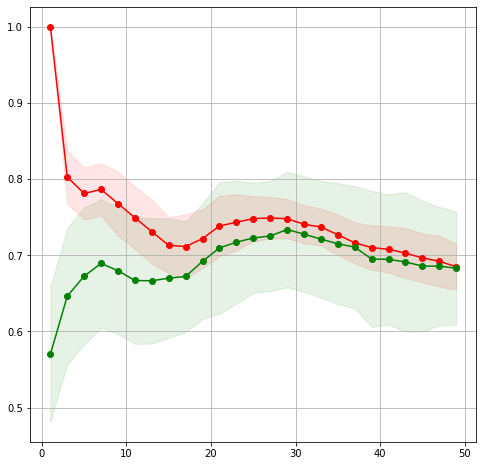

In [5]:
# Classifier: kNN
# Preprocessing: PCA
# Dataset: training & validation

# kNN will be plotted for the scoring of the classifiers

k_list = list(range(1, 50, 2))
all_train = []
all_validation = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        validation_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_pca, X_validation_pca = data_preprocessing_pca(X_train, X_validation)

        for k in k_list:
            clf_knn = KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)

            # Test the classifier on the training data and plot
            score_train = clf_knn.score(X_train_pca, y_train)
            score_validation = clf_knn.score(X_validation_pca, y_validation)            

            train_scores.append(score_train)
            validation_scores.append(score_validation)

        all_train.append(train_scores)
        all_validation.append(validation_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_validation = np.array(all_validation)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

validation_scores_mean = all_validation.mean(axis=0)
validation_scores_std = all_validation.std(axis=0)

# Plot the learning curves (mean scores and the std as shading)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, validation_scores_mean, 'o-', color="g",
        label="Validation score")

The above graphics show the trend of the kNN. Another method for obtaining the exact number of neighbors which works best in a certain fold is using a GridSearch. The use of a GridSearch is shown below. 

In [6]:
# Classifier: kNN
# Preprocessing: PCA
# Dataset: training & validation
# Use of GridSearchCV to determine k 

clf_knn = KNeighborsClassifier()

# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {"n_neighbors": list(range(1, 50, 2))}

cv_5fold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(clf_knn, parameters, cv=cv_5fold, scoring='roc_auc')

result = []
for _ in range(20):
    X_train_pca, X_validation_pca = data_preprocessing_pca(split_X_train, X_validation)
    grid_search.fit(X_train_pca, split_y_train)
    print(grid_search.best_params_)

{'n_neighbors': 43}
{'n_neighbors': 47}
{'n_neighbors': 27}
{'n_neighbors': 23}
{'n_neighbors': 31}
{'n_neighbors': 39}
{'n_neighbors': 33}
{'n_neighbors': 45}
{'n_neighbors': 29}
{'n_neighbors': 27}
{'n_neighbors': 29}
{'n_neighbors': 49}
{'n_neighbors': 49}
{'n_neighbors': 39}
{'n_neighbors': 43}
{'n_neighbors': 47}
{'n_neighbors': 33}
{'n_neighbors': 43}
{'n_neighbors': 39}
{'n_neighbors': 35}


As you can see in the results above, the optimal number of neighbors varies a lot between folds.

In [7]:
# Classifier: kNN
# Preprocessing: PCA
# Dataset: test
# Use of GridSearchCV to determine k

clf_knn = KNeighborsClassifier()

# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {"n_neighbors": list(range(1, 50, 2))}

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(clf_knn, parameters, cv=cv_4fold, scoring='roc_auc')

train_all = []
test_all = []

for _ in range(10):
    for train_index, test_index in cv_4fold.split(data, y):
        train_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_pca, X_test_pca = data_preprocessing_pca(X_train, X_test)
        grid_search.fit(X_train_pca, y_train) 
        clf_knn = grid_search.best_estimator_

        # Test
        train_proba = clf_knn.predict_proba(X_train_pca)[:, 1]
        test_proba = clf_knn.predict_proba(X_test_pca)[:, 1]

        score_train = metrics.roc_auc_score(y_train, train_proba)
        score_test = metrics.roc_auc_score(y_test, test_proba)

        train_scores.append(score_train)
        test_scores.append(score_test)

    train_all.append(train_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(train_all)
all_test = np.array(test_all)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(test_scores_mean)
print(test_scores_std)

[0.80612245]
[0.06442526]


The above results are quite good if we want to achieve an AUC of 70% or higher. However, the AUC varies and there is also a big variance in the standard deviation. Therefore, we have to adapt our model to achieve better and more robust results. The nearest neighbor hyperparameter is already tuned, so we will look at the preprocessing steps and make some adjustments. We will look at the Univariate Analysis as a preprocessing step. Below, only the train-validation curve is plotted.

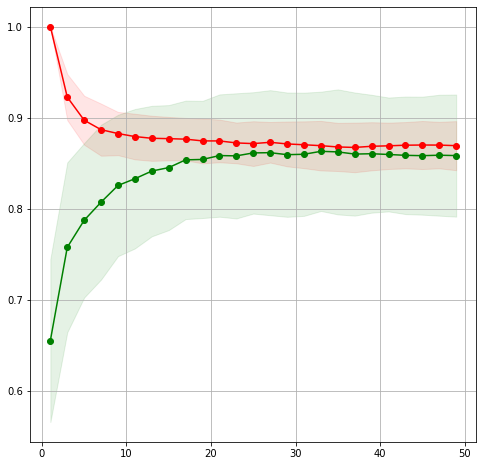

In [8]:
# Classifier: kNN
# Preprocessing: Univariate Analysis
# Dataset: training & validation

# AUROC of different values for K in kNN

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)

k_list = list(range(1, 50, 2))
all_train = []
all_test = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_uni, X_validation_uni = data_preprocessing_uni(X_train, y_train, X_validation)

        for k in k_list:
            clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_uni, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(X_train_uni)[:, 1]
            test_proba = clf_knn.predict_proba(X_validation_uni)[:, 1]
            
            score_train = metrics.roc_auc_score(y_train, train_proba)
            score_test = metrics.roc_auc_score(y_validation, test_proba)

            train_scores.append(score_train)
            test_scores.append(score_test)

        all_train.append(train_scores)
        all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the learning curves (mean scores and the std as shading)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")

The graph above shows a higher AUROC with an AUC score above the 70%. Next, the hyperparameter tuning using GridSearch is applied in the 'inner' loop on the test set. 

In [9]:
# Classifier: kNN
# Preprocessing: Univariate Analysis
# Dataset: test
# Use of GridSearchCV to determine k

clf_knn = KNeighborsClassifier()

parameters = {"n_neighbors": list(range(1, 50, 2))}

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(clf_knn, parameters, cv=cv_4fold, scoring='roc_auc')

train_all = []
test_all = []
for _ in range(4):
    for train_index, test_index in cv_4fold.split(data, y):
        train_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_uni, X_test_uni = data_preprocessing_uni(X_train, y_train, X_test)

        grid_search.fit(X_train_uni, y_train) 
        clf_knn = grid_search.best_estimator_

        # Tests 
        train_proba = clf_knn.predict_proba(X_train_uni)[:, 1]
        test_proba = clf_knn.predict_proba(X_test_uni)[:, 1]

        score_train = metrics.roc_auc_score(y_train, train_proba)
        score_test = metrics.roc_auc_score(y_test, test_proba)

        train_scores.append(score_train)
        test_scores.append(score_test)

    train_all.append(train_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(train_all)
all_test = np.array(test_all)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(test_scores_mean)
print(test_scores_std)

[0.85076531]
[0.04185928]


# Logistic Regression

# Bijlagen
1. Preprocessing
2. Classifiers

# 1.a PCA

The number of samples: 113
The number of features: 159


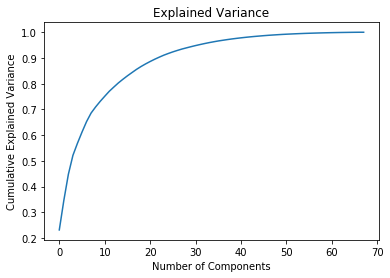

In [15]:
# Determining number of components for PCA

# Loading of the data 
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) 
# 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y, stratify=y,test_size=0.2)

# Loop over the folds
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]

    # Scale data
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    #PCA
    pca = PCA().fit(X_train_scaled)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance')
plt.show()

# 1.b RFECV

In the beginning we also tried using RFECV as a preprocessing step combined with imputing the missing data, the definition of this function is shown below. We tried a lot of the possible combinations, but it didn't show any value to preprocessing our data. 

In [ ]:
def data_preprocessing(X_train, y_train):
    '''Data preprocessing: Scaling, RFECV, PCA, Imputation missing data'''

    # 1. Scaling
    scaler = preprocessing.StandardScaler()
    # scaler = preprocessing.MinMaxScaler()
    # scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # 2. Feature selection/extraction
    # Create the Recursive Feature Elimination object and compute a cross-validated score.
    svc = svm.SVC(kernel="linear")

    rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=model_selection.StratifiedKFold(4), scoring='roc_auc')
    rfecv.fit(X_train_scaled, y_train)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    print("Optimal number of features : %d" % rfecv.n_features_)

    # 3. PCA
    n_selected_features = rfecv.n_features_
    n_samples = X_train.shape
    n_components == min(n_samples, n_selected_features)
    pca = decomposition.PCA(n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)

    # 4. Imputation missing data
    missing_values=[0.0, 1.0]
    for elem in missing_values:
        imputer = KNNImputer(missing_values=elem, n_neighbors=5, weights='uniform')
        X_train_imputed = imputer.fit_transform(X_train_pca)

    return X_train_imputed